<center><b><font size=6>Unsupervised learning – clustering<b><center>

This notebook ...

0. **Install Dependencies**
1. **Determine the Number of Clusters**
2. **Tune Other Hyperparameters**
3. **Visualize the Clusters**
4. **Cluster Analysis**
5. **Assess Homogeneity and Intent Reflection**
6. **Associate Clusters with Specific Attack Categories**

<center><b><font size=5>Install Dependencies<b><center>

In [3]:
!python ../scripts/install_dependencies.py section3

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
python: can't open file '../scripts/install_dependencies.py': [Errno 2] No such file or directory


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

<center><b><font size=5>Determine the Number of Clusters<b><center>

Identify the optimal number of clusters using evaluation methods like the Elbow Method or Silhouette Analysis.

**Steps:**

- Evaluate Data for Clustering
- Apply Clustering Evaluation Techniques
- Decide and Document

### Evaluate Data for Clustering

- Preprocess the text sessions (e.g., tokenize and vectorize using TF-IDF or word embeddings).
- Ensure data is normalized and ready for clustering.

In [5]:

df_features_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf_sampled.parquet")


X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
df_features_tfidf_sampled.describe

<bound method NDFrame.describe of                                           Set_Fingerprint    enable    system  \
45459                            [Discovery, Persistence]  0.136394  0.068782   
73366                            [Discovery, Persistence]  0.136394  0.068782   
142247                           [Discovery, Persistence]  0.136394  0.068782   
207369                           [Discovery, Persistence]  0.136394  0.068782   
187475                           [Discovery, Persistence]  0.136394  0.068782   
...                                                   ...       ...       ...   
171360                                           [Impact]  0.000000  0.000000   
166018  [Discovery, Persistence, Defense Evasion, Harm...  0.000000  0.105743   
132486  [Discovery, Persistence, Defense Evasion, Impa...  0.000000  0.135173   
171506        [Discovery, Impact, Execution, Persistence]  0.000000  0.141465   
232782        [Discovery, Impact, Execution, Persistence]  0.000000  0.1097

### Apply Clustering Evaluation Techniques

- Use the Elbow Method:
  - Calculate the sum of squared distances (inertia) for a range of cluster numbers.
  - Plot inertia vs. the number of clusters to identify the "elbow" point.
- Use Silhouette Analysis:
  - Compute the silhouette score for each potential cluster number.
  - Plot silhouette scores to find the number with the highest score.

### Decide and Document

- Select the optimal number of clusters based on the evaluation.
- Visualize and explain the reasoning with supporting metrics and charts.

In [6]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cl_labels = kmeans_new.fit_predict(X)
        
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(silhouette_value)

    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

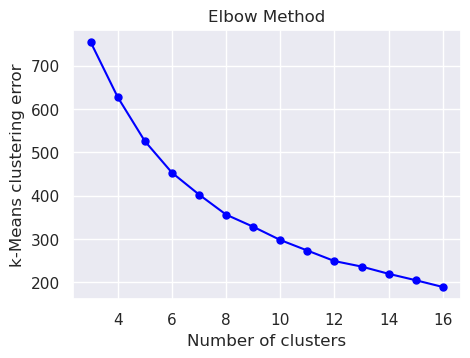

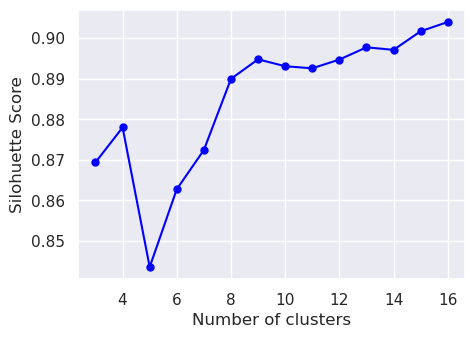

Size of each cluster:  [ 8399 10365  1787    61   946    34    92   388   272    40    32   567
    23    43   229    47]


In [7]:
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set_theme(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

(unique, counts) = np.unique(kmeans_new.labels_, return_counts=True)
print("Size of each cluster: ", counts)

In [14]:
n_cluster_list=[]
silhouette_list_gmm= []
log_l_list=[]

for n_clusters in range(3, 17):
    gmm = GaussianMixture(n_components = n_clusters, random_state=42)
    gmm_label = gmm.fit_predict(X)
      
    silhouette_value = silhouette_score(X, gmm_label)
    silhouette_list_gmm.append(silhouette_value)
    
    log_l_list.append(gmm.score(X))
    n_cluster_list.append(n_clusters)

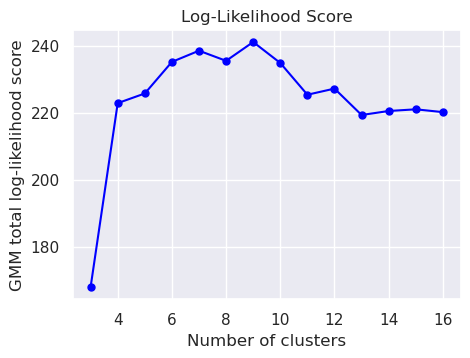

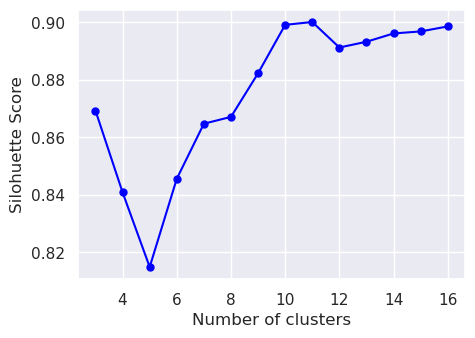

Effetive size of each cluster:  [0.36008574 0.43494105 0.07661308 0.00261522 0.04021436 0.00145766
 0.00394427 0.01659164 0.01642015 0.0017149  0.00137192 0.02430868
 0.00098607 0.00184352 0.01487674 0.00201501]


In [15]:
# Set up Seaborn style
sns.set_theme(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list_gmm, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

# report effective size
print("Effetive size of each cluster: ", gmm.weights_)

<center><b><font size=5>Tune Other Hyperparameters<b><center>

## KMEANS

In [19]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  list(range(2, 21, 2)),
    'max_iter':  list(range(50, 501, 50)),
}

# Create KMeans object
kmeans = KMeans(n_clusters=10, random_state=42)

# Create RandomizedSearchCV object
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=5)

# Fit the randomized search to your data
grid_search_kmeans.fit(X)  # X is your dataset

# Get the best parameters
best_params_kmenas = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmenas)

Best parameters: {'init': 'k-means++', 'max_iter': 150, 'n_init': 16}


In [20]:
kmeans_tuned = KMeans(n_clusters=10, init=best_params_kmenas['init'], n_init=best_params_kmenas['n_init'], max_iter=best_params_kmenas['max_iter'], random_state=42)
cl_labels_tuned = kmeans_tuned.fit_predict(X)
    
silhouette_value= silhouette_score(X, kmeans_tuned.labels_)

inertia = (kmeans_tuned.inertia_)
print("Silhouette: ", silhouette_value)
print("Inertia: ", inertia)

Silhouette:  0.8930553254823349
Inertia:  297.5640267859936


## GMM

In [ ]:
def silhouette_scorer(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

param_grid_gmm = {
    'init_params': ['kmeans'], 
    'covariance_type': ['full', 'spherical'], # 'tied', 'diag' have been deleted because never selected
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': list(range(50, 300, 50)),
}

# Create GaussianMixture object
gmm = GaussianMixture(n_components=10,random_state=42)

# Create GridSearchCV object
grid_search_gmm = GridSearchCV(gmm, param_grid_gmm, cv=5, scoring = silhouette_scorer)

# Fit the grid search to your data
grid_search_gmm.fit(X)  # X is your dataset

# Get the best parameters
best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

In [ ]:
gmm_tuned = GaussianMixture(n_components = 10, random_state=42, init_params=best_params_gmm['init_params'], covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_tuned = gmm_tuned.fit_predict(X)
    
silhouette_value = silhouette_score(X, gmm_label_tuned)

log_l_tuned = (gmm_tuned.score(X))

print("Silhouette: ", silhouette_value)
print("Log-l: ", log_l_tuned)

<center><b><font size=5>Visualize the Clusters: t-SNE<b><center>

In [ ]:
#LET'S APPLY THE t-SNE TO THE DATASET, TO REDUCE THE NUMBER OF COMPONENTS

originalDF = pd.DataFrame(X)

tsne = TSNE(n_components=2, random_state=42).fit_transform(originalDF.values)

df_tsne = pd.DataFrame(tsne)
df_tsne

#NOW WE HAVE THE 2 COMPONENTS and WE CAN APPLY IT TO BOTH THE ALGORITHM

## KMEANS

In [ ]:
labels_kmeans_tuned = kmeans_tuned.labels_

df_tsne_kmeans = pd.DataFrame(df_tsne)
df_tsne_kmeans["cluster"] = labels_kmeans_tuned
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]


fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_kmeans, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")
ax.set_title('TSNE Cluster Visualization using K-Means with K=10')
df_tsne_kmeans

## GMM

In [ ]:
labels_gmm_tuned = gmm_tuned.predict(X)


df_tsne_gmm = pd.DataFrame(df_tsne)
df_tsne_gmm["cluster"] = labels_gmm_tuned
df_tsne_gmm.columns = ["x1", "x2", "cluster"]


fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")
ax.set_title('TSNE Cluster Visualization using GMM with K=10')
df_tsne_gmm

Use t-SNE or UMAP to create clear visual representations of the clusters.

**Steps:**

- Reduce Dimensionality
- Create Visual Representations
- Analyze and Save

### Reduce Dimensionality

- Apply t-SNE or UMAP to reduce the data to two or three dimensions for visualization.
- Normalize or scale data if required by the algorithm.

### Create Visual Representations

- Plot the data points with cluster assignments using a scatter plot:
  - Assign distinct colors to each cluster.
  - Add legends and labels for clarity.

### Analyze and Save

- Highlight overlaps or ambiguous clusters in the visualization.
- Save the plots and include them in your report for analysis.

<center><b><font size=5>Cluster Analysis<b><center>

Examine and interpret each cluster’s defining characteristics using word clouds and frequent terms.

**Steps:**

- Identify Key Characteristics
- Describe Cluster Patterns
- Document Insights

### Identify Key Characteristics

- Extract the most frequent words or phrases in each cluster.
- Generate word clouds to visually represent the distinctive terms for each cluster.

### Describe Cluster Patterns

- Analyze relationships or patterns among clusters:
  - Are clusters clearly separated or overlapping?
  - What types of terms dominate each cluster?

### Document Insights

- Summarize findings for each cluster with observations about their unique traits.

<center><b><font size=5>Assess Homogeneity and Intent Reflection<b><center>

Evaluate how well clusters align with intents and assess their homogeneity.

**Steps:**

- Match Clusters to Intents
- Analyze Homogeneity
- Draw Conclusions

### Match Clusters to Intents

- Compare each cluster to the dataset’s labeled intents (e.g., Persistence, Discovery, etc.).
- Use metrics like the homogeneity score or manual inspection to evaluate alignment.

### Analyze Homogeneity

- Check if clusters are homogeneous (single intent) or mixed (multiple intents).
- Record insights into intent distribution within clusters.

### Draw Conclusions

- Discuss the implications of the findings:
  - Are clusters meaningful in terms of attack intents?
  - What could improve clustering accuracy?

<center><b><font size=5>Associate Clusters with Specific Attack Categories<b><center>

Analyze selected clusters to identify finer-grained attack categories and unique behaviors.

**Steps:**

- Select Representative Clusters
- Analyze Cluster Contents
- Relate to Practical Scenarios

### Select Representative Clusters

- Choose a few clusters that show interesting or unique behavior for deeper analysis.

### Analyze Cluster Contents

- Examine the sessions in these clusters:
  - Identify patterns or behaviors that distinguish them.
  - Determine subcategories of attacks within these clusters.

### Relate to Practical Scenarios

- Link findings to real-world attack methodologies:
  - Use graph-based techniques or manual inspection for further refinement.
- Present results with examples and interpretations to showcase finer attack categorization.